# Imports

In [9]:

import pandas as pd
import numpy as np
import h2o
from h2o.automl import H2OAutoML
from matplotlib import pyplot as plt
h2o.init()



Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,2 hours 6 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_olejacobmellgren_f51fon
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.491 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


# Load datasets

In [2]:
X_train_estimated_a = pd.read_parquet('../data/A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../data/B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../data/C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../data/A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../data/B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../data/C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../data/A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../data/B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../data/C/X_test_estimated.parquet')

train_targets_a = pd.read_parquet('../data/A/train_targets.parquet')
train_targets_b = pd.read_parquet('../data/B/train_targets.parquet')
train_targets_c = pd.read_parquet('../data/C/train_targets.parquet')



# Data clean up

In [3]:

# Data set A, B and C clean up

def data_clean_up(x_train_est, x_train_observe, y_train):

  if 'date_calc' in x_train_est.columns:
    x_train_est.drop(columns="date_calc", inplace=True)

  x_train = pd.concat([x_train_observe, x_train_est])

  # Group the rows into blocks of 4 and apply the aggregation function
  agg_func = {col: 'mean' for col in x_train.columns[1:]}
  X_train_downscaled = x_train.groupby(x_train.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

  y_train.dropna(inplace=True)
  combined_data = pd.merge(X_train_downscaled, y_train, left_on='date_forecast', right_on='time')
  y_train = combined_data['pv_measurement']

  if 'date_forecast' and 'time' and 'pv_measurement' in combined_data.columns:
    combined_data.drop(columns="date_forecast", inplace=True)
    combined_data.drop(columns="time", inplace=True)
    # combined_data.drop(columns="pv_measurement", inplace=True)

  return combined_data, y_train

x_train_a, y_train_a = data_clean_up(X_train_estimated_a, X_train_observed_a, train_targets_a)
x_train_b, y_train_b = data_clean_up(X_train_estimated_b, X_train_observed_b, train_targets_b)
x_train_c, y_train_c = data_clean_up(X_train_estimated_c, X_train_observed_c, train_targets_c)


def data_clean_up_test(x_test_est):

  # Group the rows into blocks of 4 and apply the aggregation function
  agg_func = {col: 'mean' for col in x_test_est.columns[1:]}
  X_test_downscaled = x_test_est.groupby(x_test_est.index // 4).agg({**{'date_forecast': 'first'}, **agg_func})

  if 'date_forecast' in X_test_downscaled.columns:
    X_test_downscaled.drop(columns="date_forecast", inplace=True)

  return X_test_downscaled

X_test_estimated_a = data_clean_up_test(X_test_estimated_a)
X_test_estimated_b = data_clean_up_test(X_test_estimated_b)
X_test_estimated_c = data_clean_up_test(X_test_estimated_c)

# Feature engineering

In [4]:

# Data set A, B and C to H2O

def data_to_h2o(x_train, y_train, x_test):
  
    x_train_h2o = h2o.H2OFrame(x_train)
    y_train = y_train.to_frame()
    y_train_h2o = h2o.H2OFrame(y_train)
    x_test_h2o = h2o.H2OFrame(x_test)
  
    return x_train_h2o, y_train_h2o, x_test_h2o

x_train_a_h2o, y_train_a_h2o, x_test_a_h2o = data_to_h2o(x_train_a, y_train_a, X_test_estimated_a)
x_train_b_h2o, y_train_b_h2o, x_test_b_h2o = data_to_h2o(x_train_b, y_train_b, X_test_estimated_b)
x_train_c_h2o, y_train_c_h2o, x_test_c_h2o = data_to_h2o(x_train_c, y_train_c, X_test_estimated_c)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


# Training the model

In [5]:
print(y_train_a_h2o)
aml_a = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
aml_b = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)
aml_c = H2OAutoML(max_models=10, seed=1, max_runtime_secs=3600)

aml_a.train(x=x_train_a_h2o.columns, y=y_train_a_h2o.columns[0], training_frame=x_train_a_h2o)
aml_b.train(x=x_train_b_h2o.columns, y=y_train_b_h2o.columns[0], training_frame=x_train_b_h2o)
aml_c.train(x=x_train_c_h2o.columns, y=y_train_c_h2o.columns[0], training_frame=x_train_c_h2o)

  pv_measurement
            0
            0
            0
            0
           19.36
          251.02
          263.78
          522.72
          904.42
         1238.82
[29667 rows x 1 column]

AutoML progress: |
11:48:06.647: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
11:49:29.639: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]


11:49:35.616: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

████
11:50:33.264: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██████
11:51:23.573: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

███
11:53:15.214: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

█
11:53:54.888: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██
11:54:34.779: _train param, Dropping bad and constant columns: [snow_drift:idx, elevation:m]

██


key,value
Stacking strategy,cross_validation
Number of base models (used / total),10/20
# GBM base models (used / total),4/7
# XGBoost base models (used / total),6/6
# DRF base models (used / total),0/2
# DeepLearning base models (used / total),0/4
# GLM base models (used / total),0/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


# Evaluate training

In [6]:
lb = aml_a.leaderboard
lb.head(rows=lb.nrows) 


model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20231009_114806,399.174,159340,187.888,nan,159340
StackedEnsemble_BestOfFamily_1_AutoML_1_20231009_114806,403.616,162906,188.192,nan,162906
GBM_4_AutoML_1_20231009_114806,411.87,169637,192.354,nan,169637
GBM_grid_1_AutoML_1_20231009_114806_model_1,414.834,172088,196.795,nan,172088
GBM_3_AutoML_1_20231009_114806,418.607,175232,197.494,nan,175232
GBM_2_AutoML_1_20231009_114806,420.172,176544,199.488,nan,176544
XGBoost_grid_1_AutoML_1_20231009_114806_model_2,424.749,180412,198.195,nan,180412
GBM_5_AutoML_1_20231009_114806,432.464,187025,206.32,nan,187025
GBM_1_AutoML_1_20231009_114806,433.423,187856,206.909,nan,187856
XRT_1_AutoML_1_20231009_114806,436.879,190863,205.627,0.821009,190863


# Make predictions

In [7]:
y_pred_a = aml_a.leader.predict(x_test_a_h2o)
y_pred_b = aml_b.leader.predict(x_test_b_h2o)
y_pred_c = aml_c.leader.predict(x_test_c_h2o)

y_pred_a = y_pred_a.as_data_frame()
y_pred_b = y_pred_b.as_data_frame()
y_pred_c = y_pred_c.as_data_frame()

y_pred = pd.concat([y_pred_a, y_pred_b, y_pred_c], axis=0, ignore_index=True)


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


# Create submission

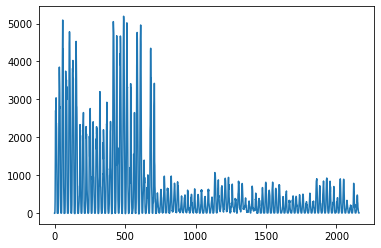

In [10]:
plt.plot(y_pred)

In [8]:
test = pd.read_csv('../data/test.csv')
test['prediction'] = y_pred['predict']
sample_submission = pd.read_csv('../data/sample_submission.csv')
submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
submission.to_csv('submission.csv', index=False)